<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau
from sklearn.metrics import mean_absolute_error

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(0)

## Neural Network

A simple Fully Connected Neural Network

In [0]:
# GPU info
# !nvidia-smi

### Data Processing

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[2:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log(float(x)))

# drop Ipc
datasets = datasets.drop(['Ipc'], axis=1)
cols.remove('Ipc')

Get the left censored and right censored sorted out.

In [0]:
# input and output
y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

# qualifiers classification
s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# > greater
rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# < lower
lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

Check features.

In [152]:
corr = datasets.corr()
corr.loc[(corr['pIC50'] >= 0.4) | (corr['pIC50'] <= -0.4)]['pIC50'][1:]

qed                        0.491180
MolWt                     -0.526664
BertzCT                   -0.503721
PEOE_VSA1                 -0.450455
PEOE_VSA3                 -0.465307
SMR_VSA1                  -0.427446
SlogP_VSA2                -0.509821
TPSA                      -0.533955
EState_VSA2               -0.467875
VSA_EState9               -0.454508
NOCount                   -0.529112
NumAromaticHeterocycles   -0.400436
NumHAcceptors             -0.487935
NumHeteroatoms            -0.593323
NumRotatableBonds         -0.463759
fr_Ar_COO                 -0.486644
f_111                     -0.478565
f_186                     -0.459100
f_456                     -0.492155
f_667                      0.419061
f_807                     -0.456968
f_1242                    -0.411416
f_1403                    -0.471330
f_1601                    -0.400506
f_1634                     0.420678
f_2147                    -0.470485
f_2238                    -0.471330
f_2287                    -0

Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

### Loss function (with censored data)

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff
    l = y_pred - lcutoff
    # qualifiers adjusted Loss function
    #return K.mean((1-s0)*K.square(z), axis=-1)
    return K.mean((1-s0)*K.square(z) + s2*K.relu(-r) + s1*K.relu(l), axis=-1)

### Fully Connected NN

The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data, neural networks mostly. Here we will normalize the features and $\log{\text{IC50}}$ to have zero-mean and unit-standard-deviation `BatchNormalization`.

In [0]:
# Function to create model
def create_model(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=50, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=50))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    # hidden layer
    model.add(Dense(units=25))
    model.add(Activation("relu"))
    # output layer
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

### Run Lola, Run

Parameters are not optimized! Do Grid search.

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network = None 
network = create_model(input_dim) 

# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      batch_size=50,                    # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

### Evaluation

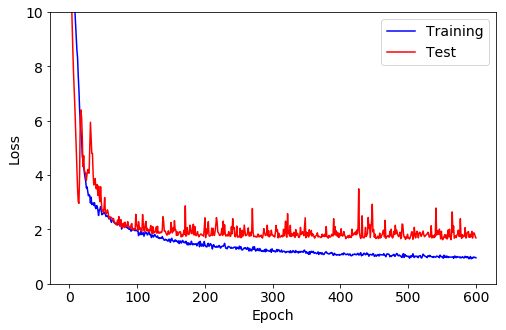

In [11]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

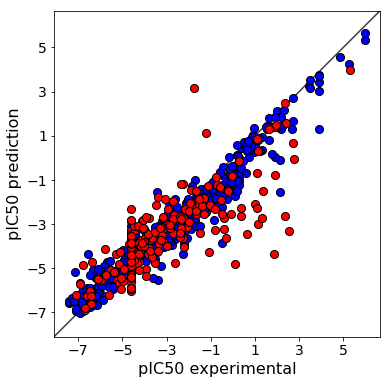

In [12]:
plt.rcParams["figure.figsize"] = (18,6)    # plot size
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, network.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

#c = y_test.astype(int)
c = 'red'
ax.scatter(y_test, network.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [13]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7964980882077582
MAE         : 0.8832642557712428
Kendall Tau : 0.6481220340877224


### Cross-validation

In [14]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    network = None
    network = create_model(x_test.shape[1]) 
    network.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.809153301341655
MAE         : 0.9942259883906319
Kendall Tau : 0.654106074076847
#------------------------#
R2          : 0.804227961927518
MAE         : 0.9914633105554119
Kendall Tau : 0.6546160619581007
#------------------------#
R2          : 0.8053976566434053
MAE         : 1.171547971527283
Kendall Tau : 0.6520967619073165
#------------------------#
R2          : 0.8450364347320932
MAE         : 0.9180266385427651
Kendall Tau : 0.7104690203429456


## Shallow (A Star Is Born)

In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
# Clearing the NN
shallow = None 
shallow = create_linear(input_dim)                      # model

# Train shallow model
history = shallow.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=600,                       # Number of epochs
                      verbose=0,                        # No output
                      validation_data=(x_test, y_test)) # Data for evaluation

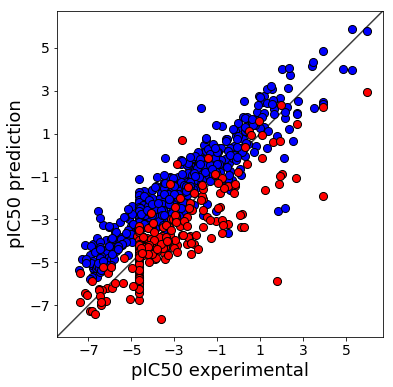

In [17]:
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, shallow.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

c = 'red'
ax.scatter(y_test, shallow.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=18)
ax.set_ylabel("pIC50 prediction",   fontsize=18)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8250859848099684
MAE         : 1.5154271500692655
Kendall Tau : 0.6557421907617613


In [19]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    shallow = None 
    shallow = create_model(x_test.shape[1])
    shallow.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7740804366006887
MAE         : 1.0003504024623886
Kendall Tau : 0.6094905860497533
#------------------------#
R2          : 0.8169517865978575
MAE         : 1.2194588601646583
Kendall Tau : 0.6724362617982684
#------------------------#
R2          : 0.7985937283401975
MAE         : 1.0134309238926655
Kendall Tau : 0.6533428066752923
#------------------------#
R2          : 0.8432263740258066
MAE         : 0.9770257303787888
Kendall Tau : 0.6750575423786499


## Control

Ignore censored data

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff
    l = y_pred - lcutoff
    # qualifiers adjusted Loss function
    return K.mean((1-s0)*K.square(z), axis=-1)
    #return K.mean((1-s0)*K.square(z) + s2*K.relu(-r) + s1*K.relu(l), axis=-1)

### Another day at work

In [0]:
%%capture

# input dimensions
input_dim = x.shape[1]

# fix random seed
seed = 84
np.random.seed(seed)

# Clearing the NN
network2 = None 
network2 = create_model(input_dim) 

# Train neural network
history = network2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       batch_size=50,                    # Number of observations per batch
                       validation_data=(x_test, y_test)) # Data for evaluation

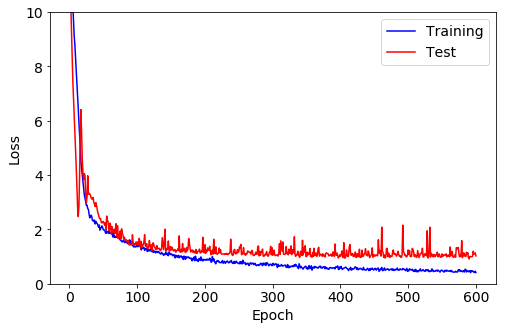

In [22]:
plt.rcParams["figure.figsize"] = (8,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Training', 'Test'], fontsize=14)
plt.ylim([0,10])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

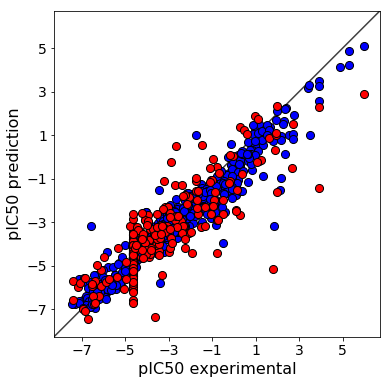

In [23]:
plt.rcParams["figure.figsize"] = (18,6)    # plot size
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, network2.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

#c = y_test.astype(int)
c = 'red'
ax.scatter(y_test, network2.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [24]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8433738387504034
MAE         : 0.865666205991386
Kendall Tau : 0.6869546792441247


In [25]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    network2 = None
    network2 = create_model(x_test.shape[1]) 
    network2.fit(x_train, y_train, epochs=600, verbose=0, batch_size=50)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7801272547103614
MAE         : 0.9415520105657833
Kendall Tau : 0.6406451025725605
#------------------------#
R2          : 0.819781840096332
MAE         : 0.9834120808546839
Kendall Tau : 0.6733341788444784
#------------------------#
R2          : 0.822838467552391
MAE         : 0.9560747202881713
Kendall Tau : 0.6619958953417906
#------------------------#
R2          : 0.844768359115287
MAE         : 0.872417804389031
Kendall Tau : 0.6705786202645888


### Jaws 2 was terrible



In [0]:
# Function to create model
def create_linear(x):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(units=1, 
                    input_shape=(x, ), 
                    kernel_initializer='random_uniform',
                    bias_initializer='ones'))
    model.add(BatchNormalization())
    model.add(Activation("linear"))
    
    model.compile(loss=custom_loss,                     # Custom loss function
                  optimizer=Adam(lr=1e-4, decay=1e-6),  # Adam optimizer
                  metrics=['accuracy']) 	            # measure performace
    return model

In [0]:
# Clearing the NN
shallow2 = None 
shallow2 = create_linear(input_dim)                      # model

# Train shallow model
history = shallow2.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=600,                       # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

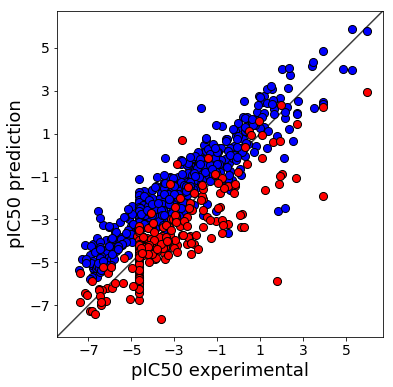

In [0]:
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, shallow2.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

c = 'red'
ax.scatter(y_test, shallow2.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=18)
ax.set_ylabel("pIC50 prediction",   fontsize=18)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [0]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.8250859848099684
MAE         : 1.5154271500692655
Kendall Tau : 0.6557421907617613


In [0]:
kf = KFold(n_splits=4, random_state=3, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    shallow2 = None 
    shallow2 = create_model(x_test.shape[1])
    shallow2.fit(x_train, y_train, epochs=600, verbose=0)
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow2.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow2.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow2.predict(x_test)[:,0])
    
    print("#------------------------#")
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

#------------------------#
R2          : 0.7740804366006887
MAE         : 1.0003504024623886
Kendall Tau : 0.6094905860497533
#------------------------#
R2          : 0.8169517865978575
MAE         : 1.2194588601646583
Kendall Tau : 0.6724362617982684
#------------------------#
R2          : 0.7985937283401975
MAE         : 1.0134309238926655
Kendall Tau : 0.6533428066752923
#------------------------#
R2          : 0.8432263740258066
MAE         : 0.9770257303787888
Kendall Tau : 0.6750575423786499


## Validation

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/BindingDB_Gyrase_B_features.tsv"
validset = pd.read_csv(filepath)

# Rename columns
validset.rename(columns={'IC50':'pIC50'}, inplace=True)
validset.rename(columns={'Ligand SMILES':'Molecule SMILES'}, inplace=True)

# Modify dataset
validset['pIC50'] = validset['pIC50'].apply(lambda x: np.log(float(x)))
validset = validset.drop(['Ipc'], axis=1)

# New columns
pattern = "[<]"
filters = validset.Censorship.str.contains(pattern)
validset["left_saturated"] = filters

pattern = "[>]"
filters = validset.Censorship.str.contains(pattern)
validset["right_saturated"] = filters

# Reorder dataframe
cols = validset.columns.tolist()
cols = cols[:1] + cols[-4:] + cols[1:-4]
validset = validset[cols]

# Reorder dataframe
validset = validset[list(datasets.columns)]

# Remove SMILES
validset = validset[~validset['Molecule SMILES'].isin(datasets['Molecule SMILES'].values)]

In [0]:
# input and output
y = validset['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = validset.iloc[:,4:].copy()
x = x.astype('float64').to_numpy()

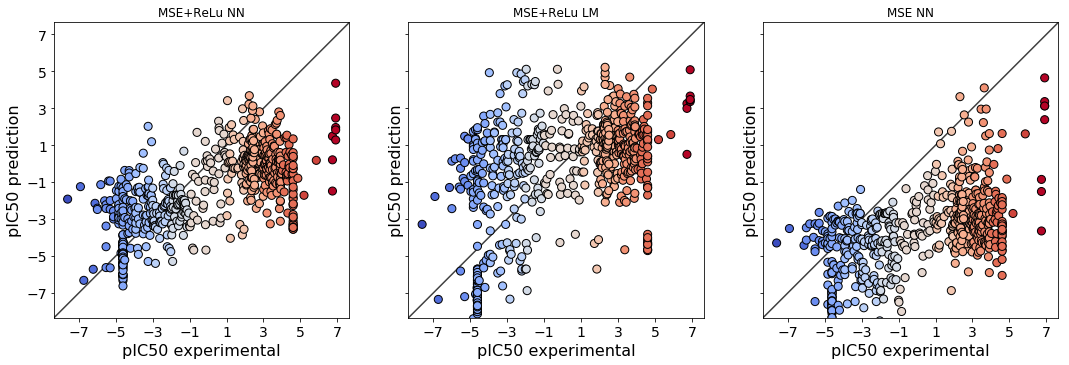

In [63]:
plt.rcParams["figure.figsize"] = (18,6)    # plot size
fig, axes = plt.subplots(2, 2, sharey=True)

#-------------------------------------------------------------- PLOT 1
ax = axes[0]

c = y.astype(int)
ax.scatter(y, network.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE+ReLu NN')

#-------------------------------------------------------------- PLOT 2
ax = axes[1]

c = y.astype(int)
ax.scatter(y, network2.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE NN')

#-------------------------------------------------------------- PLOT 3
ax = axes[2]

c = y.astype(int)
ax.scatter(y, shallow.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE+ReLu LM')

#-------------------------------------------------------------- PLOT 4
ax = axes[3]

c = y.astype(int)
ax.scatter(y, shallow2.predict(x), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=16)
ax.set_ylabel("pIC50 prediction",   fontsize=16)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.title.set_text('MSE LM')

plt.show()